# What are the differences in effects of lockdowns on mobility in different countries and how do these effects translate to the mental health status of their citizens?

In this part, we will try to answer to answer this question. In order to do that, we will look at the evolution of mental health perception (Stress and loneliness) accross time using COVIDiSTRESS dataset. Then we will look at the pageviews concerning these specific topics during the same period of time as COVIDiSTRESS survey. WE will then continue adn do the same with the mobility, using google dataset of mobility. And finally we will look, if there is a correlation between thes 3 effects, if there is one. As explained, in the README, we will conduct this analysis on 4 countries in particular: Italy, the Netherlands, Sweden, and Poland, as they all had different measured applied.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pingouin as pg
import scikit_posthocs as sp
import seaborn as sns
import json
import gzip
import scipy.stats as sc
import statsmodels.sandbox.stats as ss

from datetime import date, timedelta
from scipy import stats
from pingouin import kruskal
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)

In [2]:
DATA_PATH = "data/"

INTERVENTIONS_DATASET = DATA_PATH + "interventions.csv"
GLOBAL_MOBILITY_DATASET = DATA_PATH + "Global_Mobility_Report.csv.gz"
TOPICS_LINKED_DATASET = DATA_PATH + "topics_linked.csv.xz"
AGGREGATED_JSON = DATA_PATH + "aggregated_timeseries.json.gz"
COVIDISTRESS_PATH = 'COVIDISTRESS_unprocess_data/'
APPLE_MOBILITY_DATASET = DATA_PATH + "applemobilitytrends.csv"

NL_PAGEVIEWS_DATASET = DATA_PATH + "pageviews_nl.csv"
IT_PAGEVIEWS_DATASET = DATA_PATH + "pageviews_it.csv"
PL_PAGEVIEWS_DATASET = DATA_PATH + "pageviews_pl.csv"
SV_PAGEVIEWS_DATASET = DATA_PATH + "pageviews_sv.csv"


### Covidistress process

In [3]:
#Get the Covidistress data
df_april = pd.read_csv(DATA_PATH + 'df_covidistress_april.csv')
df_mai = pd.read_csv(DATA_PATH + 'df_covidistress_mai.csv')
df_june = pd.read_csv(DATA_PATH + 'df_covidistress_june.csv')

C:\Users\josan\AppData\Local\Temp\ipykernel_12904\1022568980.py:3: DtypeWarning: Columns (55,56,57,58,59,60,61) have mixed types. Specify dtype option on import or set low_memory=False.
  df_mai = pd.read_csv(DATA_PATH + 'df_covidistress_mai.csv')
C:\Users\josan\AppData\Local\Temp\ipykernel_12904\1022568980.py:4: DtypeWarning: Columns (54,55,56,57,58,59,60,65,66,67,68,69) have mixed types. Specify dtype option on import or set low_memory=False.
  df_june = pd.read_csv(DATA_PATH + 'df_covidistress_june.csv')


In [4]:
#get median of Stress, and loneliness in each months
PSS10_col = [col for col in df_april if col.startswith('Scale_PSS10_UCLA')]
SLON_col_april = [col for col in df_april if col.startswith('Scale_Lon')]
SLON_col = [col for col in df_mai if col.startswith('Scale_SLON')]
#april
df_april['median_stress'] = np.floor(df_april[PSS10_col].median(axis=1))
df_april['median_loneliness'] = np.floor(df_april[SLON_col_april].median(axis=1))
#mai
df_mai['median_stress'] = np.floor(df_mai[PSS10_col].median(axis=1))
df_mai['median_loneliness'] = np.floor(df_mai[SLON_col].median(axis=1))
#june
df_june['median_stress'] = np.floor(df_june[PSS10_col].median(axis=1))
df_june['median_loneliness'] = np.floor(df_june[SLON_col].median(axis=1))

In [5]:
#count and print nan values in Slon and PSS10
months = ['April', 'Mai', 'June']
#april
print('NA in April stress: ', df_april['median_stress'].isna().sum())
print('In april loneliness: ', df_april['median_loneliness'].isna().sum())
print('Tot in April: ', len(df_april['median_stress']))

#mai
print('NA in Mai stress: ', df_mai['median_stress'].isna().sum())
print('In Mai loneliness: ', df_mai['median_loneliness'].isna().sum())
print('Tot in Mai: ', len(df_mai['median_stress']))

#june
print('NA in June stress: ', df_june['median_stress'].isna().sum())
print('In June loneliness: ', df_june['median_loneliness'].isna().sum())
print('Tot in June: ', len(df_june['median_stress']))

NA in April stress:  5878
In april loneliness:  6041
Tot in April:  83525
NA in Mai stress:  6302
In Mai loneliness:  6476
Tot in Mai:  88877
NA in June stress:  6336
In June loneliness:  6511
Tot in June:  89179


In [6]:
#drop nan values in median_stress and median_loneliness for each month
medians_col = ['median_stress', 'median_loneliness']
df_april_filtered = df_april.dropna(subset=medians_col)
df_mai_filtered = df_mai.dropna(subset=medians_col)
df_june_filtered = df_june.dropna(subset=medians_col)

#check if there are still nan values
print('NA in April stress: ', df_april_filtered['median_stress'].isna().sum())
print('In april loneliness: ', df_april_filtered['median_loneliness'].isna().sum())
print('Tot in April: ', len(df_april_filtered['median_stress']))

#mai
print('NA in Mai stress: ', df_mai_filtered['median_stress'].isna().sum())
print('In Mai loneliness: ', df_mai_filtered['median_loneliness'].isna().sum())
print('Tot in Mai: ', len(df_mai_filtered['median_stress']))

#june
print('NA in June stress: ', df_june_filtered['median_stress'].isna().sum())
print('In June loneliness: ', df_june_filtered['median_loneliness'].isna().sum())
print('Tot in June: ', len(df_june_filtered['median_stress']))



NA in April stress:  0
In april loneliness:  0
Tot in April:  77464
NA in Mai stress:  0
In Mai loneliness:  0
Tot in Mai:  82380
NA in June stress:  0
In June loneliness:  0
Tot in June:  82646


In [7]:
#new feature period
df_april_filtered['period'] = 'April'
df_mai_filtered['period'] = 'Mai'
df_june_filtered['period'] = 'June'

#merge all the dataframes
df_covidistress = pd.concat([df_april_filtered, df_mai_filtered, df_june_filtered])

C:\Users\josan\AppData\Local\Temp\ipykernel_12904\3344792511.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_april_filtered['period'] = 'April'
C:\Users\josan\AppData\Local\Temp\ipykernel_12904\3344792511.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mai_filtered['period'] = 'Mai'
C:\Users\josan\AppData\Local\Temp\ipykernel_12904\3344792511.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [8]:
#keep only data from 4 countries
COUNTRIES_INTEREST = ['Italy', 'Sweden', 'Netherlands', 'Poland']
df_covidistress = df_covidistress[df_covidistress['Country'].isin(COUNTRIES_INTEREST)]

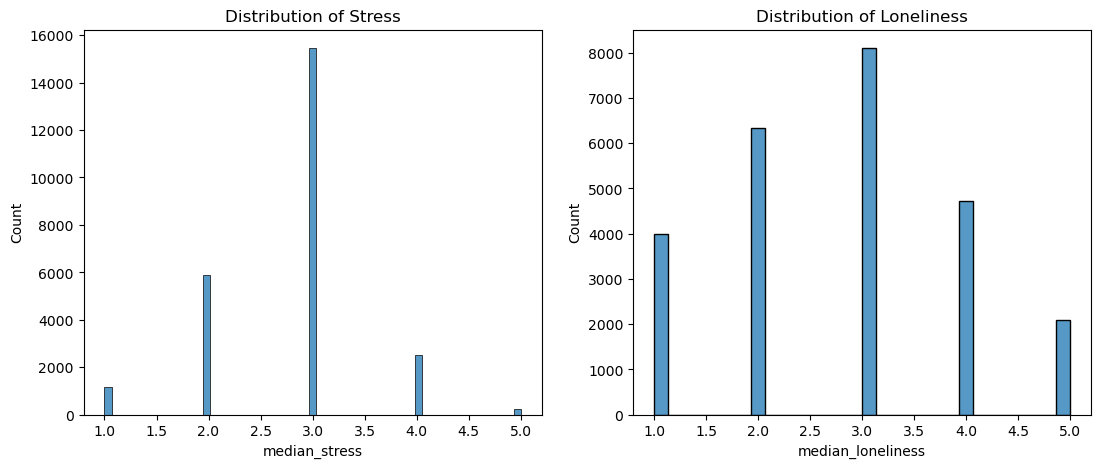

In [9]:
#plot the distribution of stress and loneliness in all 4 countries
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
sns.histplot(df_covidistress['median_stress'], ax=ax[0])
sns.histplot(df_covidistress['median_loneliness'], ax=ax[1])
ax[0].set_title('Distribution of Stress')
ax[1].set_title('Distribution of Loneliness')
plt.show()



In [10]:
#dicretize stress and loneliness in 3 categories no effect, low effect, high effect
df_covidistress['stress_cat'] = pd.cut(df_covidistress['median_stress'], bins=3, labels=[1, 3, 5])
df_covidistress['loneliness_cat'] = pd.cut(df_covidistress['median_loneliness'], bins=3, labels=[1, 3, 5])
df_covidistress

,Unnamed: 0,Duration..in.seconds.,RecordedDate,UserLanguage,Dem_age,Dem_gender,Dem_edu,Dem_edu_mom,Dem_employment,Country,...,Scale_UCLA_TRI_3,Scale_UCLA_TRI_4,PS_PTSD_1,PS_PTSD_2,PS_PTSD_3,PS_PTSD_4,PS_PTSD_5,Scale_UCLA_TRI_avg,stress_cat,loneliness_cat
1,2.0,1323,2020-04-27 04:17:16,NL,52,Male,"College degree, bachelor, master",Up to 12 years of school,Self-employed,Netherlands,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,3
49,104.0,1821,2020-04-26 15:30:19,SV,62,Female,"College degree, bachelor, master",Up to 6 years of school,Full time employed,Sweden,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
54,130.0,1443,2020-04-26 12:52:27,NL,40,Female,"Some College, short continuing education or eq...",Up to 6 years of school,Part time employed,Netherlands,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,3
58,138.0,1205,2020-04-26 12:04:02,PL,42,Female,Up to 12 years of school,Up to 12 years of school,Full time employed,Poland,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,5
59,139.0,2092,2020-04-26 12:12:32,PL,26,Female,"Some College, short continuing education or eq...",College degree,Full time employed,Poland,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83084,120307.0,770,2020-03-30 04:04:57,EN,24,Male,"College degree, bachelor, master",Up to 12 years of school,Student,Italy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1
83117,120340.0,908,2020-03-30 03:48:45,EN,25,Female,"College degree, bachelor, master",Up to 12 years of school,Not employed,Italy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1
83211,120435.0,1215,2020-03-30 02:38:46,DA,28,Female,"College degree, bachelor, master",Up to 12 years of school,Full time employed,Sweden,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1
83256,120481.0,1189,2020-03-30 01:58:47,DA,67,Female,"College degree, bachelor, master",Up to 12 years of school,Retired,Sweden,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1


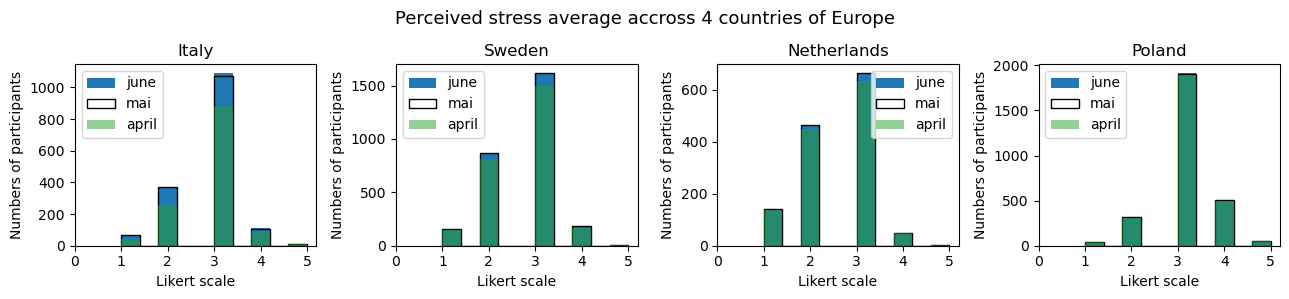

In [11]:
#list of months to choose data set and countries of interests
MONTHS = ['june', 'mai', 'april']
COUNTRIES_INTEREST = ['Italy', 'Sweden', 'Netherlands', 'Poland']

#plot histogramme of the stress median by country
fig, ax = plt.subplots(1, 4, figsize=(13, 3))
axes = ax.flatten()

for country, axe in zip(COUNTRIES_INTEREST, axes):
    #get loc in df by countries of interest and month
    df_hist_june = df_june_filtered.loc[df_june_filtered['Country'] == country]
    df_hist_mai = df_mai_filtered.loc[df_mai_filtered['Country'] == country]
    df_hist_april = df_april_filtered.loc[df_april_filtered['Country'] == country]
    #plot
    axe.hist(df_hist_june['median_stress'][:])
    axe.hist(df_hist_mai['median_stress'][:], stacked=True, fill=False)
    axe.hist(df_hist_april['median_stress'][:], alpha = .5)
    #settings for plot
    axe.set_title(country)
    axe.legend(MONTHS)
    axe.xaxis.set_ticks(range(6))
    axe.xaxis.set_ticklabels(['0', '1', '2', '3', '4', '5'])
    #labels
    axe.set_ylabel('Numbers of participants')
    axe.set_xlabel('Likert scale')

fig.suptitle('Perceived stress average accross 4 countries of Europe', fontsize=13)
fig.tight_layout()
fig.subplots_adjust(top=0.8)

In [12]:
df_covidistress['median_stress'].describe()

count    25226.000000
mean         2.790216
std          0.713062
min          1.000000
25%          2.000000
50%          3.000000
75%          3.000000
max          5.000000
Name: median_stress, dtype: float64

#### Kruskal Wallis testing for significance
##### Stress

In [13]:
alpha_sidak = 1 - (1 - 0.05) ** (1 / 3) # Bonferroni correction

In [14]:
#anova test for stress perception
df_covidistress.anova(dv='median_stress', between=['period', 'Country'])

,Source,SS,DF,MS,F,p-unc,np2
0,period,0.225377,2.0,0.112688,0.245275,0.782491,0.000019
1,Country,1238.612678,3.0,412.870893,898.646135,0.000000,0.096594
2,period * Country,2.286001,6.0,0.381000,0.829277,0.546951,0.000197
3,Residual,11584.233533,25214.0,0.459437,NaN,NaN,NaN


As we can see here only Country shows significant effect

In [15]:
sp.posthoc_tukey_hsd(df_covidistress['median_stress'], df_covidistress['Country'], alpha=alpha_sidak)

,Italy,Netherlands,Poland,Sweden
Italy,1,1,1,1
Netherlands,1,1,1,1
Poland,1,1,1,1
Sweden,1,1,1,1


In [16]:
sp.posthoc_conover(df_covidistress, val_col='median_stress', group_col='Country', p_adjust='sidak')

,Italy,Netherlands,Poland,Sweden
Italy,1.000000e+00,4.113532e-96,6.111039e-121,1.133456e-27
Netherlands,4.113532e-96,1.000000e+00,0.000000e+00,5.162962e-38
Poland,6.111039e-121,0.000000e+00,1.000000e+00,0.000000e+00
Sweden,1.133456e-27,5.162962e-38,0.000000e+00,1.000000e+00


##### Perceived loneliness

In [17]:
df_covidistress.anova(dv='median_loneliness', between=['period', 'Country'])

,Source,SS,DF,MS,F,p-unc,np2
0,period,0.598883,2.0,0.299441,0.230234,7.943490e-01,0.000018
1,Country,1383.262324,3.0,461.087441,354.520932,1.567319e-225,0.040474
2,period * Country,5.315165,6.0,0.885861,0.681121,6.649423e-01,0.000162
3,Residual,32793.151819,25214.0,1.300593,NaN,NaN,NaN


In [18]:
sp.posthoc_conover(df_covidistress, val_col='median_loneliness', group_col='Country', p_adjust='sidak')

,Italy,Netherlands,Poland,Sweden
Italy,1.000000e+00,1.977629e-18,5.116782e-48,1.251611e-19
Netherlands,1.977629e-18,1.000000e+00,6.154861e-126,7.461907e-01
Poland,5.116782e-48,6.154861e-126,1.000000e+00,1.039639e-175
Sweden,1.251611e-19,7.461907e-01,1.039639e-175,1.000000e+00


In [19]:
sp.posthoc_tukey_hsd(df_covidistress['median_loneliness'], df_covidistress['Country'], alpha=alpha_sidak)

,Italy,Netherlands,Poland,Sweden
Italy,1,1,1,1
Netherlands,1,1,1,0
Poland,1,1,1,1
Sweden,1,0,1,1


### Wiki pageviews process

In [20]:
EFFECT_DURATION = 10
LANGUAGES = ['nl', 'sv', 'pl', 'it']
region = {
    'nl':'Netherlands',
    'sv':'Sweden',
    'pl':'Poland',
    'it':'Italy'
}
diseases_names = {
    'en':['anxiety', 'depression', 'insomnia', 'loneliness', 'stress'],
    'nl':['Bezorgdheid', 'Depressie (klinisch)', 'Slapeloosheid', 'Eenzaamheid', 'Stress'],
    'it':['Ansia', 'Disturbo depressivo', 'Insonnia', 'Solitudine', 'Stress'],
    'sv':['Ångest', 'Depression', 'Sömnlöshet', 'Ensamhet', 'Stress'],
    'pl':['Lęk', 'Zaburzenia depresyjne', 'Bezsenność', 'Samotność', 'Stres']
}

In [21]:
interventions_data = pd.read_csv(INTERVENTIONS_DATASET)
apple_mobility_data = pd.read_csv(APPLE_MOBILITY_DATASET, low_memory=False)
google_mobility_data = pd.read_csv(GLOBAL_MOBILITY_DATASET, compression='gzip', low_memory=False)

pageviews_data = {}
pageviews_data['nl'] = pd.read_csv(NL_PAGEVIEWS_DATASET, low_memory=False)
pageviews_data['it'] = pd.read_csv(IT_PAGEVIEWS_DATASET, low_memory=False)
pageviews_data['sv'] = pd.read_csv(SV_PAGEVIEWS_DATASET, low_memory=False)
pageviews_data['pl'] = pd.read_csv(PL_PAGEVIEWS_DATASET, low_memory=False)

In [22]:
interventions_data.set_index('lang', inplace=True)
#augment data with interventions date in poland
interventions_data.loc['pl'] = [np.nan, '2020-03-12', '2020-03-12', np.nan,'2020-03-12', np.nan, np.nan]
interventions_data

,1st case,1st death,School closure,Public events banned,Lockdown,Mobility,Normalcy
lang,,,,,,,
fr,2020-01-24,2020-02-14,2020-03-14,2020-03-13,2020-03-17,2020-03-16,2020-07-02
da,2020-02-27,2020-03-12,2020-03-13,2020-03-12,2020-03-18,2020-03-11,2020-06-05
de,2020-01-27,2020-03-09,2020-03-14,2020-03-22,2020-03-22,2020-03-16,2020-07-10
it,2020-01-31,2020-02-22,2020-03-05,2020-03-09,2020-03-11,2020-03-11,2020-06-26
nl,2020-02-27,2020-03-06,2020-03-11,2020-03-24,NaN,2020-03-16,2020-05-29
no,2020-02-26,2020-02-26,2020-03-13,2020-03-12,2020-03-24,2020-03-11,2020-06-04
sr,2020-03-06,2020-03-20,2020-03-15,2020-03-21,2020-03-21,2020-03-16,2020-05-02
sv,2020-01-31,2020-03-11,2020-03-18,2020-03-12,NaN,2020-03-11,2020-06-05
ko,2020-01-20,2020-02-20,2020-02-23,NaN,NaN,2020-02-25,2020-04-15


In [23]:
for col in interventions_data.columns:
    interventions_data[col] = pd.to_datetime(interventions_data[col])

apple_mobility_data = apple_mobility_data.drop(columns = ['alternative_name', 'country', 'sub-region'], axis=1)

In [24]:
#function from q2

def is_affected(lang, effect, day):
    x = interventions_data[effect].loc[lang]
    if x == pd.NaT:
        return 0
    if day >= x and day < x + timedelta(days=EFFECT_DURATION):
        return 1
    return 0

def is_lockdown(lang, day):
    start = interventions_data['Lockdown'].loc[lang]
    end = interventions_data['Normalcy'].loc[lang]
    if start == pd.NaT or end == pd.NaT:
        return 0
    if day >= start and day < end:
        return 1
    return 0

def get_pageviews_data(lang):
    df = pageviews_data[lang].copy()
    df.rename(columns = dict(zip(diseases_names[lang], diseases_names['en'])), inplace = True)
    df['Date'] = pd.to_datetime(df['Date'])
    df['Day_of_the_week'] = df['Date'].apply(lambda x: x.strftime("%A"))
    df['first_case'] = df['Date'].apply(lambda x: is_affected(lang, '1st case', x))
    df['first_death'] = df['Date'].apply(lambda x: is_affected(lang, '1st death', x))
    df['lockdown'] = df['Date'].apply(lambda x: is_lockdown(lang, x))
    df['month'] = df['Date'].apply(lambda date: date.month) #add month

    df.set_index('Date', inplace=True)
    df = df[diseases_names['en'] + ['Day_of_the_week', 'first_case', 'first_death', 'lockdown', 'month']]
    return df

def get_apple_data(lang):
    df = apple_mobility_data.loc[apple_mobility_data['region'] == region[lang]]
    if lang == 'pl': #no transit data for poland
        df.index = ['driving', 'walking']
    else:
        df.index = ['driving', 'transit', 'walking']
    df = df.drop(columns = ['geo_type', 'region' ,'transportation_type'], axis = 1)
    df = df.T
    df.index = pd.to_datetime(df.index)
    return df

def get_google_data(lang):
    df = google_mobility_data[google_mobility_data['country_region_code'] == lang.upper()]
    df = df[df['sub_region_1'].isna()] #keep only rows with country level data (for italy only using sub_region_1 is enough)
    df = df.dropna(axis=1, how='all') #keep only rows without NaN values(should drop all "sub_region"s)
    df = df.interpolate() #replace NaN values with average of bfill and ffill (No NaN values in this filtered dataframe but not necessarily the case)
    df.set_index(pd.DatetimeIndex(df['date']), inplace = True)
    del df['date']
    df = df.drop_duplicates()
    df.rename(columns = {'retail_and_recreation_percent_change_from_baseline':'retail',
                        'grocery_and_pharmacy_percent_change_from_baseline':'grocery',
                        'parks_percent_change_from_baseline':'parks',
                        'transit_stations_percent_change_from_baseline':'stations',
                        'workplaces_percent_change_from_baseline':'workplaces',
                        'residential_percent_change_from_baseline':'residential'},
                        inplace = True)
    return df

def merge_datasets(pageviews, apple, google):
    df = pd.merge(pageviews, apple, left_index=True, right_index=True)
    df = pd.merge(df, google, left_index=True, right_index=True)
    return df

def loop(lang, diseases):
    pageviews = get_pageviews_data(lang)
    apple = get_apple_data(lang)
    google = get_google_data(lang)
    df = merge_datasets(pageviews, apple, google)
    return df
        


In [25]:
#get dataframes for each country
df_pv_italy_all = loop('it', diseases_names['en'])
df_pv_netherlands_all = loop('nl', diseases_names['en'])
df_pv_sweden_all = loop('sv', diseases_names['en'])
df_pv_poland_all = loop('pl', diseases_names['en'])

START_CD = pd.to_datetime('2020-03-30')
END_CD = pd.to_datetime('2020-06-17')
#get points from START_CD to END_CD in each country dataframe
df_pv_italy = df_pv_italy_all.loc[START_CD:END_CD]
df_pv_netherlands = df_pv_netherlands_all.loc[START_CD:END_CD]
df_pv_sweden = df_pv_sweden_all.loc[START_CD:END_CD]
df_pv_poland = df_pv_poland_all.loc[START_CD:END_CD]


In [26]:
#Settigns the start and end of each period
START_APRIL = START_CD
END_APRIL = pd.to_datetime('2020-04-27')
START_MAI = pd.to_datetime('2020-04-28')
END_MAI = pd.to_datetime('2020-05-30')
START_JUNE = pd.to_datetime('2020-05-31')
END_JUNE = END_CD

#italy
#add column 'period' to dataframe if index between 30/03/2020 and 27/04/2020, 27/04/2020 and 30/05/2020, 30/05/2020 and 17/06/2020
df_pv_italy.loc[:, 'period'] = 'march' #set default value
df_pv_italy.loc[START_APRIL:END_APRIL, 'period'] = 'april' #check if date between 30/03/2020 and 27/04/2020
df_pv_italy.loc[START_MAI:END_MAI, 'period'] = 'mai' #check if date between 27/04/2020 and 30/05/2020
df_pv_italy.loc[START_JUNE:END_JUNE, 'period'] = 'june' #check if date between 30/05/2020 and 17/06/2020

#netherlands
df_pv_netherlands.loc[:,'period'] = 'march' #set default value
df_pv_netherlands.loc[START_APRIL:END_APRIL, 'period'] = 'april' #check if date between 30/03/2020 and 27/04/2020
df_pv_netherlands.loc[START_MAI:END_MAI, 'period'] = 'mai' #check if date between 27/04/2020 and 30/05/2020
df_pv_netherlands.loc[START_JUNE:END_JUNE, 'period'] = 'june' #check if date between 30/05/2020 and 17/06/2020

#sweden
df_pv_sweden.loc[:,'period'] = 'march' #set default value
df_pv_sweden.loc[START_APRIL:END_APRIL, 'period'] = 'april' #check if date between 30/03/2020 and 27/04/2020
df_pv_sweden.loc[START_MAI:END_MAI, 'period'] = 'mai' #check if date between 27/04/2020 and 30/05/2020
df_pv_sweden.loc[START_JUNE:END_JUNE, 'period'] = 'june' #check if date between 30/05/2020 and 17/06/2020

#poland
df_pv_poland.loc[:,'period'] = 'march' #set default value
df_pv_poland.loc[START_APRIL:END_APRIL, 'period'] = 'april' #check if date between 30/03/2020 and 27/04/2020
df_pv_poland.loc[START_MAI:END_MAI, 'period'] = 'mai' #check if date between 27/04/2020 and 30/05/2020
df_pv_poland.loc[START_JUNE:END_JUNE, 'period'] = 'june' #check if date between 30/05/2020 and 17/06/2020


#df_pv_netherlands.groupby(df_pv_netherlands['period']).count()
#df_pv_poland.groupby(df_pv_poland['period']).count()
df_pv_sweden.groupby(df_pv_sweden['period']).count()


C:\Users\josan\AppData\Local\Temp\ipykernel_12904\3688499.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pv_italy.loc[:, 'period'] = 'march' #set default value
C:\Users\josan\AppData\Local\Temp\ipykernel_12904\3688499.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pv_netherlands.loc[:,'period'] = 'march' #set default value
C:\Users\josan\AppData\Local\Temp\ipykernel_12904\3688499.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

,anxiety,depression,insomnia,loneliness,stress,Day_of_the_week,first_case,first_death,lockdown,month,...,transit,walking,country_region_code,country_region,retail,grocery,parks,stations,workplaces,residential
period,,,,,,,,,,,,,,,,,,,,,
april,29,29,29,29,29,29,29,29,29,29,...,29,29,29,29,29,29,29,29,29,29
june,18,18,18,18,18,18,18,18,18,18,...,18,18,18,18,18,18,18,18,18,18
mai,33,33,33,33,33,33,33,33,33,33,...,31,31,33,33,33,33,33,33,33,33


In [27]:
#merge all dataframes in one
df_pv_italy.loc[:,'country'] = 'italy'
df_pv_netherlands.loc[:,'country'] = 'netherlands'
df_pv_sweden.loc[:,'country'] = 'sweden'
df_pv_poland.loc[:,'country'] = 'poland'

df_pv = pd.concat([df_pv_italy, df_pv_netherlands, df_pv_sweden, df_pv_poland])
df_pv

C:\Users\josan\AppData\Local\Temp\ipykernel_12904\195496966.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pv_italy.loc[:,'country'] = 'italy'
C:\Users\josan\AppData\Local\Temp\ipykernel_12904\195496966.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pv_netherlands.loc[:,'country'] = 'netherlands'
C:\Users\josan\AppData\Local\Temp\ipykernel_12904\195496966.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

,anxiety,depression,insomnia,loneliness,stress,Day_of_the_week,first_case,first_death,lockdown,month,...,country_region_code,country_region,retail,grocery,parks,stations,workplaces,residential,period,country
2020-03-30,277,527,555,105,261,Monday,0,0,1,3,...,IT,Italy,-81.0,-47.0,-79.0,-81.0,-69.0,32.0,april,italy
2020-03-31,260,501,484,135,223,Tuesday,0,0,1,3,...,IT,Italy,-90.0,-42.0,-78.0,-79.0,-70.0,33.0,april,italy
2020-04-01,250,523,379,130,228,Wednesday,0,0,1,4,...,IT,Italy,-90.0,-41.0,-77.0,-79.0,-70.0,33.0,april,italy
2020-04-02,290,635,310,91,196,Thursday,0,0,1,4,...,IT,Italy,-90.0,-40.0,-77.0,-79.0,-70.0,34.0,april,italy
2020-04-03,287,465,270,96,243,Friday,0,0,1,4,...,IT,Italy,-85.0,-37.0,-78.0,-79.0,-69.0,35.0,april,italy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-13,95,529,97,52,194,Saturday,0,0,0,6,...,PL,Poland,-17.0,-7.0,158.0,-23.0,2.0,-2.0,june,poland
2020-06-14,119,673,125,66,241,Sunday,0,0,0,6,...,PL,Poland,-2.0,5.0,125.0,-10.0,15.0,-5.0,june,poland
2020-06-15,144,696,129,60,293,Monday,0,0,0,6,...,PL,Poland,-2.0,1.0,65.0,-27.0,-20.0,4.0,june,poland
2020-06-16,141,712,142,49,303,Tuesday,0,0,0,6,...,PL,Poland,-5.0,1.0,84.0,-27.0,-20.0,5.0,june,poland


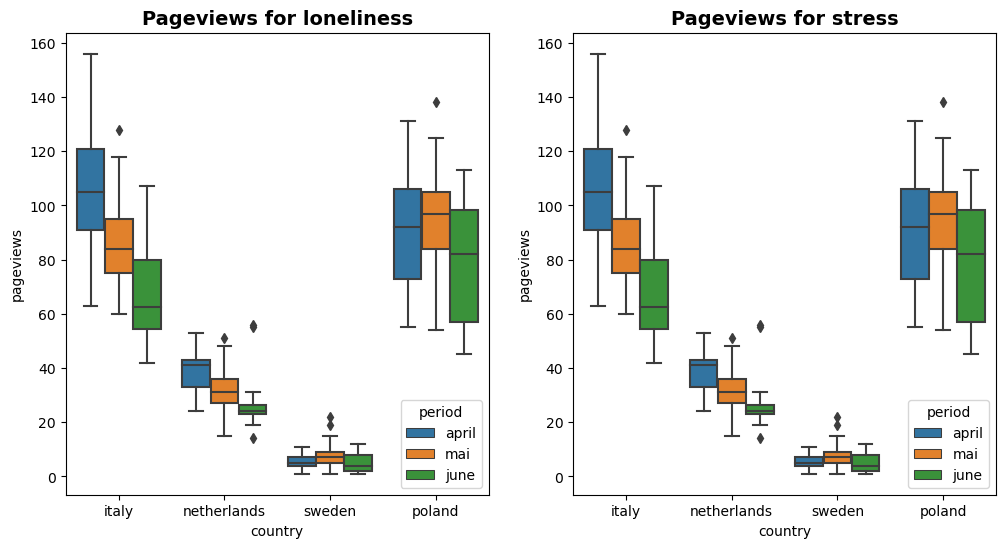

In [28]:
diseases_covidistress = ['loneliness', 'stress']
#plot pageviews for each country and period for each pagename in subplot
fig, ax = plt.subplots(1,2, figsize=(12,6))


for i in range(len(diseases_covidistress)):
    sns.boxplot(x='country', y='loneliness', hue='period', data=df_pv, ax=ax[i])
    ax[i].set_title('Pageviews for {}'.format(diseases_covidistress[i]), fontsize=14, fontweight='bold')
    ax[i].set_ylabel('pageviews')
plt.show()


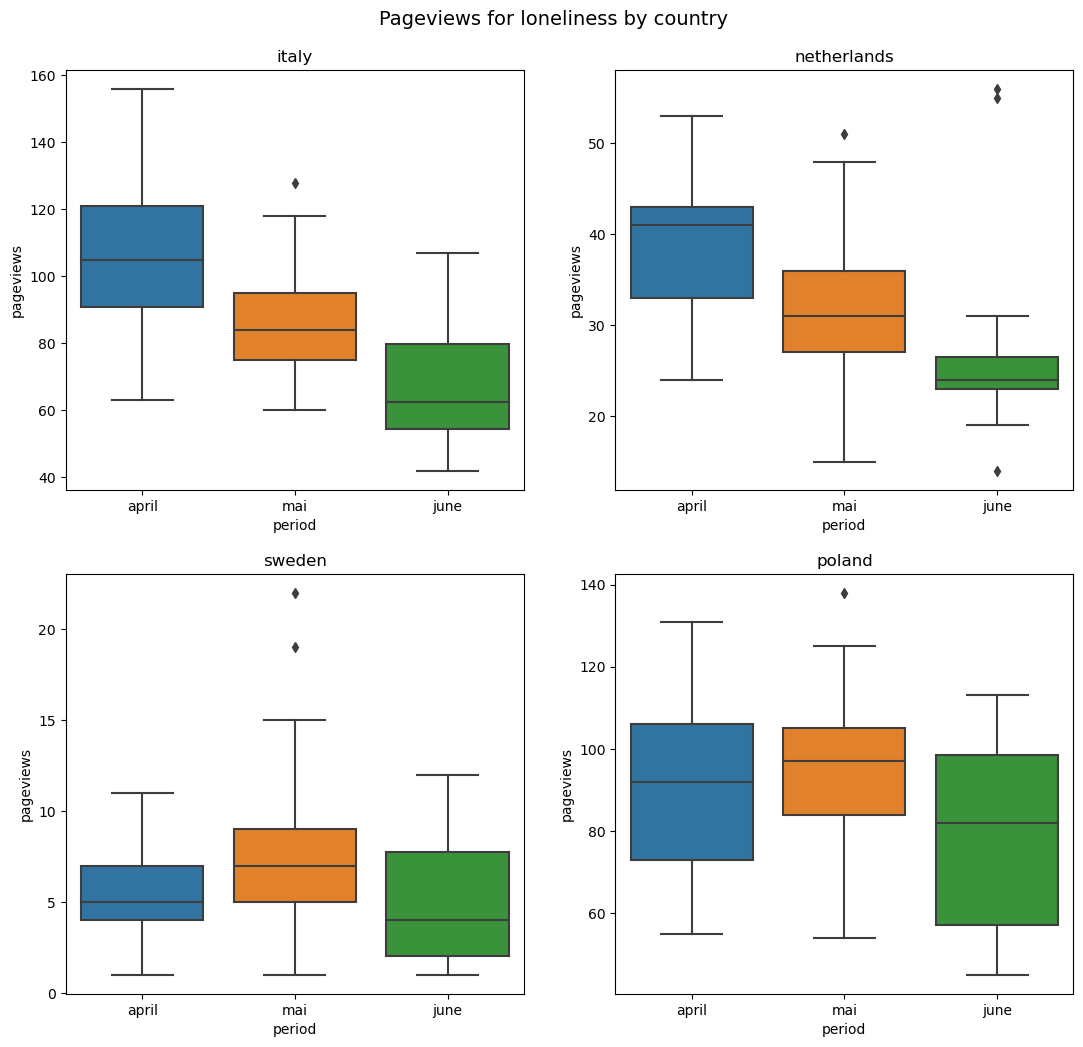

In [29]:
countries_names = ['italy', 'netherlands', 'sweden', 'poland']
#plot for each countries the pageviews for each pagename and period in subplot
fig, axes = plt.subplots(2,2, figsize = (13,12))
axs = axes.flatten()

for ax, country in zip(axs, countries_names):
    sns.boxplot(x='period', y='loneliness', data=df_pv.loc[df_pv['country'] == country], ax=ax)
    ax.set_title(country)
    ax.set_ylabel('pageviews')

fig. suptitle('Pageviews for loneliness by country', fontsize=14, y = 0.93)
plt.show()

#### ANOVA testing for each disease looking at pageviews variance in relation to periode and country

In [30]:
df_pv.anova(dv='stress', between=['period', 'country']).round(3)

,Source,SS,DF,MS,F,p-unc,np2
0,period,47119.558,2.0,23559.779,7.237,0.001,0.045
1,country,4306549.175,3.0,1435516.392,440.947,0.000,0.811
2,period * country,23373.963,6.0,3895.661,1.197,0.308,0.023
3,Residual,1002702.854,308.0,3255.529,NaN,NaN,NaN


As seen on the [Critical Values of the F-Distribution: α = 0.05 table](https://www.stat.purdue.edu/~lfindsen/stat511/F_alpha_05.pdf): We have a DoF of 120 in the denominator, hence the respectives critical values for DF 2, 3 and 6 are 3.072, 2.680 and 2.175.
Therefore, all features are significant execpt for period x country

In [31]:
alpha_sidak = 1 - (1 - 0.05) ** (1 / 3)

In [32]:
sp.posthoc_tukey_hsd(df_pv['stress'], df_pv['period'], alpha=alpha_sidak)

,april,june,mai
april,1,0,0
june,0,1,0
mai,0,0,1


In [33]:
sp.posthoc_tukey_hsd(df_pv['stress'], df_pv['country'], alpha=alpha_sidak)

,italy,netherlands,poland,sweden
italy,1,1,1,1
netherlands,1,1,1,1
poland,1,1,1,1
sweden,1,1,1,1


In [34]:
sp.posthoc_conover(df_pv, val_col='stress', group_col='period', p_adjust='sidak')

,april,june,mai
april,1.000000,0.283786,0.999999
june,0.283786,1.000000,0.258765
mai,0.999999,0.258765,1.000000


In [35]:
sp.posthoc_conover(df_pv, val_col='stress', group_col='country', p_adjust='sidak')

,italy,netherlands,poland,sweden
italy,1.000000e+00,1.128476e-46,2.992704e-28,1.072585e-90
netherlands,1.128476e-46,1.000000e+00,1.679625e-92,2.422485e-26
poland,2.992704e-28,1.679625e-92,1.000000e+00,3.222736e-129
sweden,1.072585e-90,2.422485e-26,3.222736e-129,1.000000e+00


##### Anova test and post hoc for loneliness

In [36]:
df_pv.anova(dv='loneliness', between=['period', 'country']).round(3)

,Source,SS,DF,MS,F,p-unc,np2
0,period,10139.893,2.0,5069.946,23.640,0.0,0.133
1,country,416480.059,3.0,138826.686,647.313,0.0,0.863
2,period * country,9804.645,6.0,1634.107,7.619,0.0,0.129
3,Residual,66055.575,308.0,214.466,NaN,NaN,NaN


All significant F

In [37]:
sp.posthoc_tukey_hsd(df_pv['loneliness'], df_pv['period'], alpha=alpha_sidak)

,april,june,mai
april,1,0,0
june,0,1,0
mai,0,0,1


We can see no significant difference in loneliness pageviews between the 3 periods

In [38]:
sp.posthoc_tukey_hsd(df_pv['loneliness'], df_pv['country'], alpha=alpha_sidak)

,italy,netherlands,poland,sweden
italy,1,1,0,1
netherlands,1,1,1,1
poland,0,1,1,1
sweden,1,1,1,1


Only Italy and Poland don't have significant difference in pageview loneliness

In [39]:
sp.posthoc_conover(df_pv, val_col='loneliness', group_col='period', p_adjust='sidak')

,april,june,mai
april,1.000000,0.041444,0.835877
june,0.041444,1.000000,0.173314
mai,0.835877,0.173314,1.000000


By looking at the p-values we can also see that their is no significant difference in pageview loneliness

In [40]:
sp.posthoc_conover(df_pv, val_col='loneliness', group_col='country', p_adjust='sidak')

,italy,netherlands,poland,sweden
italy,1.000000e+00,2.990555e-56,9.593625e-01,9.965409e-105
netherlands,2.990555e-56,1.000000e+00,2.152623e-59,9.304372e-33
poland,9.593625e-01,2.152623e-59,1.000000e+00,2.458533e-107
sweden,9.965409e-105,9.304372e-33,2.458533e-107,1.000000e+00


By looking at the p-values we can also see that their is significant difference in pageview loneliness accross all countries except  Italy-Poland

### Mobility